In [1]:
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_flights():
    flights = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/flights.csv')
    flights['day'] = '01'
    flights['year'] = flights['year'].astype(str)
    flights['date'] = flights[['year', 'month', 'day']].apply(lambda x: '-'.join(x), axis=1)
    flights = flights.set_index( pd.to_datetime( flights['date']) )
    flights = flights.drop(['year', 'month', 'day',  'date'], axis=1)
    return flights

In [3]:
get_flights().head()

,passengers
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


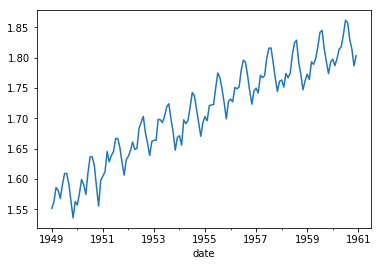

In [4]:
flights = get_flights()
flights['passengers_log'] = np.log(flights['passengers'])
_ = np.log(flights['passengers_log']).plot()

### Discussion

- trend can be seen by decreasing correlations
- seasonal cycle can be seen by dips

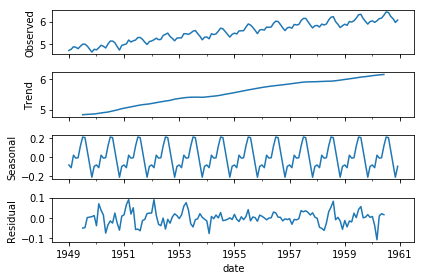

In [5]:
decomposition = sm.tsa.seasonal_decompose(flights['passengers_log'], model='additive')
fig = decomposition.plot()
plt.show()

## Estimating the trend component - additive time series

### Non-seasonal additive model - Moving Average

Non-seasonal model: $X_t = m_t + W_t$ (note no seasonal component)

How to eliminate the noise component?  Moving average

$\hat{m}_t = \frac{1}{2q + 1}(x_{t-q} + ... + x_t + ... + x_{t+q})$

2q+1 is the order. For example, for order = 3:

$\hat{m}_t = \frac{1}{3}(x_{t-1} + x_t + x_{t+1})$

**NOTE:** Flights data is non-additive and has seasonality so isn't a great example!

In [6]:
flights['passengers_ma13'] = flights['passengers'].rolling(window=11).mean()
flights = flights[ ~ np.isnan(flights['passengers_ma13']) ]

In [7]:
flights.head()

,passengers,passengers_log,passengers_ma13
date,,,
1949-11-01,104,4.644391,127.454545
1949-12-01,118,4.770685,128.000000
1950-01-01,115,4.744932,127.727273
1950-02-01,126,4.836282,127.181818
1950-03-01,141,4.948760,128.272727


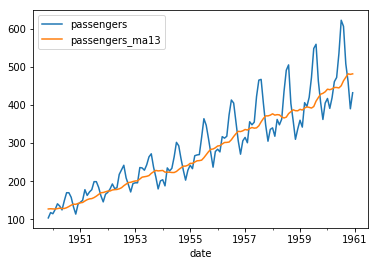

In [8]:
ax = flights['passengers'].plot(legend=True)
_ = flights['passengers_ma13'].plot(ax=ax, legend=True)

**GOAL:** choose smoothing factor high enough to reduce the noise but not too high that it loses important details in the trend.

###  Additive seasonal time series - Weighted Moving Average

Start with MA order equal to the period T of the seasonal cycle.  This smooths out seasonal variation.

However, we would want an even MA of 12 for above as we have a frequency of 12 months, but we need an uneven number of 13.  To use 13 and prevent a period getting double counted we use a weighted moving average.  The two end values have are weighted by 1/2. I.e. for order 4 ...

$SA(t) = \frac{1}{4}(0.5x_{t-2} + x_{t-1} + x_t + x_{t+1} +0.5x_{t+2})$

Weights are: $\frac{1}{4}(0.5) + \frac{1}{4} + \frac{1}{4} + \frac{1}{4} + \frac{1}{4}(0.5) = 1$

Note also that the seasonal component in $X_t = m_t + s_t + W_t$ is cancelled out:

$0.5s_{t-6} + s_{t-5} + ... + s_{t+5} + 0.5s_{t+6} = 0$

In [21]:
def weighted_mean(arr):
    denom = (len(arr) - 1)
    weights = [1.0/denom] * (len(arr) - 2)
    weights.insert(0, 0.5/denom) 
    weights.append(0.5/denom)
    assert(sum(weights))
    #print(weights)
    
    return np.average(arr, weights=weights)

data = pd.DataFrame(data={ 'value': [ 2, 3, 3, 3, 2]})
data['wma'] = data['value'].rolling(window=5, center=True).apply(lambda a: weighted_mean(a), raw=False)
data # 1/4.0 * (2*0.5 + 3 + 3 + 3 + 2*0.5) = 2.75

TypeError: unsupported operand type(s) for +: 'float' and 'list'

**NOTE:** flights data is non-additive

In [10]:
flights = get_flights()
flights['passengers_wma'] = flights['passengers'].rolling(
                                            window=13, center=True
                                        ).apply(
                                            lambda a: weighted_mean(a), raw=False
                                        )
flights = flights[ ~ np.isnan(flights['passengers_wma']) ]

In [11]:
flights.head()

,passengers,passengers_wma
date,,
1949-07-01,148,126.791667
1949-08-01,148,127.250000
1949-09-01,136,127.958333
1949-10-01,119,128.583333
1949-11-01,104,129.000000


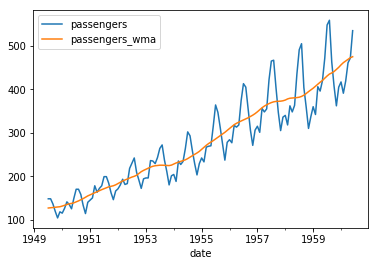

In [12]:
ax = flights['passengers'].plot(legend=True)
_ = flights['passengers_wma'].plot(ax=ax, legend=True)

Double check the frequency is monthly

In [13]:
pd.infer_freq(flights.index)

'MS'

MS = month start frequency (https://stackoverflow.com/a/35339226/1033422)

#### Remove trend component

In [14]:
flights = get_flights()

flights['passengers_wma'] = flights['passengers'].rolling(
                                            window=13, center=True
                                        ).apply(
                                            lambda a: weighted_mean(a), raw=False
                                        )
flights = flights[ ~ np.isnan(flights['passengers_wma']) ]

flights['passengers_no_seasonal'] = flights['passengers'] - flights['passengers_wma']
flights.head()

,passengers,passengers_wma,passengers_no_seasonal
date,,,
1949-07-01,148,126.791667,21.208333
1949-08-01,148,127.250000,20.750000
1949-09-01,136,127.958333,8.041667
1949-10-01,119,128.583333,-9.583333
1949-11-01,104,129.000000,-25.000000


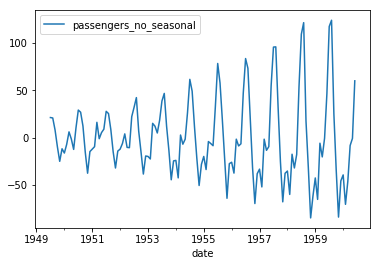

In [15]:
ax = flights['passengers_no_seasonal'].plot(legend=True)

**Question:** Should I remove the increasing magnitude?

See notebook: [transform_log_sqrt_power](./transform_log_sqrt_power.ipynb)

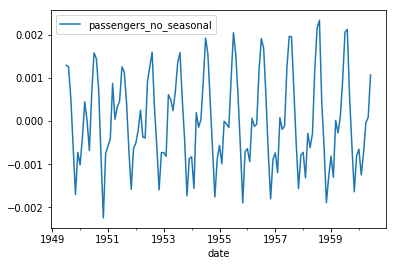

In [16]:
flights = get_flights()

# Power transform
flights['passengers_pwr'] = np.power(flights['passengers'], 1.0/128.0)

flights['passengers_wma'] = flights['passengers_pwr'].rolling(
                                            window=13, center=True
                                        ).apply(
                                            lambda a: weighted_mean(a), raw=False
                                        )
flights = flights[ ~ np.isnan(flights['passengers_wma']) ]

flights['passengers_no_seasonal'] = flights['passengers_pwr'] - flights['passengers_wma']

ax = flights['passengers_no_seasonal'].plot(legend=True)